In [47]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

import requests
from bs4 import BeautifulSoup
import re

# Preamble — Prepare to fetch data

These are the root URLs for the two kinds of requests we need to perform: filters and lists.

First, the filter dialog is used to

1. Retrieve the IDs for the years and semesters, as well as for the _Informatique_ field of study, we care about
2. Look for the ID of the associated list.

Lists contain the actual data we care about.

Both types of request use a fixed `ww_i_reportModel` constant, which we assume is used for versioning.

In [48]:
root_url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.'
report = '&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&'
filter_path = root_url + 'filter?ww_b_list=1' + report
list_path = root_url + 'html?' + report
[ filter_path, list_path ]

['http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&',
 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&']

Next, we look up the IDs for the years and semesters we're interested in.

In [49]:
# Find the IDs for the individual years

req = requests.get(filter_path)

if req.status_code != 200:
  raise Exception('Request failed')

parser = BeautifulSoup(req.text, "html.parser")

years = parser.find('select', attrs={"name": "ww_x_PERIODE_ACAD"}).findAll('option')
year_ids = {year.text: year['value'] for year in years}

year_ids

{'': 'null',
 '2007-2008': '978181',
 '2008-2009': '978187',
 '2009-2010': '978195',
 '2010-2011': '39486325',
 '2011-2012': '123455150',
 '2012-2013': '123456101',
 '2013-2014': '213637754',
 '2014-2015': '213637922',
 '2015-2016': '213638028',
 '2016-2017': '355925344'}

In [50]:
informatique_id = parser.find(
    'select',
    attrs={"name": "ww_x_UNITE_ACAD"}
).find(
    (lambda tag: tag.text == 'Informatique')
)['value']

informatique_id

'249847'

In [51]:
periods = parser.find('select', attrs={'name': 'ww_x_PERIODE_PEDAGO'})
period_ids = {}

for el in periods:
    period_ids[el.text] = el['value']

period_ids

{'': 'null',
 'Bachelor semestre 1': '249108',
 'Bachelor semestre 2': '249114',
 'Bachelor semestre 3': '942155',
 'Bachelor semestre 4': '942163',
 'Bachelor semestre 5': '942120',
 'Bachelor semestre 5b': '2226768',
 'Bachelor semestre 6': '942175',
 'Bachelor semestre 6b': '2226785',
 'Master semestre 1': '2230106',
 'Master semestre 2': '942192',
 'Master semestre 3': '2230128',
 'Master semestre 4': '2230140',
 'Mineur semestre 1': '2335667',
 'Mineur semestre 2': '2335676',
 'Mise à niveau': '2063602308',
 'Projet Master automne': '249127',
 'Projet Master printemps': '3781783',
 'Semestre automne': '953159',
 'Semestre printemps': '2754553',
 'Stage automne 3ème année': '953137',
 'Stage automne 4ème année': '2226616',
 'Stage printemps 3ème année': '983606',
 'Stage printemps 4ème année': '2226626',
 'Stage printemps master': '2227132'}

In [52]:
def get_gps_id(period, year):
    query = 'ww_x_PERIODE_PEDAGO=' + period_ids[period] + '&ww_x_PERIODE_ACAD=' + year_ids[year]
    req = requests.get(filter_path + 'ww_x_UNITE_ACAD=' + informatique_id + '&' + query)
    
    
    if req.status_code != 200:
      raise Exception('Request failed')
    
    parser = BeautifulSoup(req.text, "html.parser")

    onclick_value = parser.findAll('a', class_ = 'ww_x_GPS')[1]['onclick']
    
    return re.search('ww_x_GPS=(\\d+)', onclick_value).group(1)

get_gps_id(period='Bachelor semestre 1', year='2016-2017')

'2021043255'

In [53]:
def get_table(period, year):
    query = 'ww_x_GPS=' + get_gps_id(period, year) + '&ww_x_UNITE_ACAD=' + informatique_id
    req = requests.get(list_path + query)

    if req.status_code != 200:
      raise Exception('Request failed')

    parser = BeautifulSoup(req.text, "html.parser")

    return list(map((lambda x: [el.text for el in x.findAll('td')]), parser.findAll('tr')[2:]))

get_table(period='Bachelor semestre 6', year='2008-2009')[0]

['Monsieur',
 'Balas\xa0Martin',
 '',
 '',
 '',
 '',
 '',
 'Présent',
 '',
 '',
 '174774',
 '']

# Task 1

> Obtain all the data for the Bachelor students, starting from 2007. Keep only the students for which you have an entry for both Bachelor semestre 1 and Bachelor semestre 6. Compute how many months it took each student to go from the first to the sixth semester. Partition the data between male and female students, and compute the average -- is the difference in average statistically significant?

In [54]:
result_dict = {} 
attente = {}
conge = {}
for year in range(2007, 2017):
    for sem in range(1, 7):
        table = get_table(period='Bachelor semestre ' + str(sem), year=str(year) + '-' + str(year + 1))
        for record in table:
            statut = record[7]
            id = int(record[10])  # will raise expcetion if None or empty string 
            if  statut == 'Présent':                               
                gender = record[0] 
                if gender not in ['Monsieur', 'Madame']:
                    raise Exception('Unexpected gender:' + gender + '; sem: ' + str(sem) + ' year: ' + str(year) + ' id: ' + str(id))
                gender = int(gender == 'Monsieur')  # => 1 for Monsieur, 0 for Madame
                if id not in result_dict:
                    if sem == 1:  # we consider only students who started studying in 2007 or later
                        result_dict[id] = {'gender': gender, 'sem_count': 0, 'sems': []}
                    else:
                        continue
                else:
                    if result_dict[id]['gender'] != gender:
                        raise Expception('Inconsistent gender!')
                result_dict[id]['sem_count'] += 1
                result_dict[id]['sems'].append(str(sem) + '_' + str(year))
            elif statut == 'Congé':
                if id not in conge:
                    conge[id] = {'c_sems': [], 'c_sem_count': 0}
                conge[id]['c_sems'].append(str(sem) + '_' + str(year))
                conge[id]['c_sem_count'] += 1     
            elif statut == 'Attente':
                if id not in attente:
                    attente[id] = {'a_sems': [], 'a_sem_count': 0}
                attente[id]['a_sems'].append(str(sem) + '_' + str(year))
                attente[id]['a_sem_count'] += 1                
            else: raise Exception('Unexpected statut: ' + statut + '; sem: ' + str(sem) + ' year: ' + str(year) + ' id: ' + str(id))

In above algorithm we load all the students from desired period (2007+). For the sake of simplicity we are only interested in students who started at 2007 or later. If we were to consider students who started earlier we would have to make lots of assumptions which would result in making up data.

We also check for the status of the student at given semester. We have found 3 different types of statuses - Présent, Congé and Attente. Later on we will try to analyze their meaning and contribution.

When it comes to Période pédagogique we only take into account the Bachelor semesters 1 - 6. We have decided to ignore the Semestre automne and Semestre printemps listings as they contain only exchange students. Exchange students are staying only one semster or two and so using them in our computation would skew the averages to artificial low numbers.

We have also ignored the Mise à niveau, Bachelor Semestre 5b, Bachelor Semestre 6b listings because they are empty for entries with Unité académique set to Informatique. All the other Périodes pédagogiques (Master semestre N, Mineur semestre N, Projet Master automne/printemps) are ignored for this part of exercise because they only include master students.

We also disregard Type de semestre because it does not bring us any new information. As a rule of a thumb Bachelor semesters 1, 3 and 5 are always Semestre d'automne while Bachelor semesters 2, 4 and 6 are always Semestre de printemps.

Combination of Bachelor Semestre N with different season (e.g. Bachelor semestre 1 and Semestre de printemps) results always in empty result.

In [55]:
to_delete = []
for key, value in result_dict.items():
    if not any(sem.startswith('6') for sem in value['sems']):
        to_delete.append(key)
for key in to_delete:
    del result_dict[key]

In above code we check if student has an entry for semester 6 in his record.
If he has we assume he successfully finished his studies, even though technically the fact that he took part in 6th semester does not mean he has finished it successfully.
Then we remove all the students who don't have the entry for semester 6 in their semester list as they haven't finished the studies yet because they are not suitable for the computation. 

In [56]:
len(result_dict)

297

By the removal of irrelevant data we decreased size of our dataset from 1476 to 297 samples.

In [57]:
def intersect_dicts(dict1, dict2):
    keys_intersection = set(dict1.keys()).intersection(set(dict2.keys()))
    res = {}
    for key in keys_intersection:
        res[key] = {**dict1[key], **dict2[key]}
    return res

In [58]:
attente_int_result = set(attente.keys()).intersection(set(result_dict.keys()))
len(attente_int_result)

1

In [59]:
intersect_dicts(result_dict, attente)

{223892: {'a_sem_count': 2,
  'a_sems': ['1_2014', '2_2014'],
  'gender': 1,
  'sem_count': 9,
  'sems': ['1_2012',
   '2_2012',
   '1_2013',
   '2_2013',
   '3_2014',
   '4_2014',
   '5_2015',
   '6_2015',
   '5_2016']}}

The _Attente_ status has occurred only in 1 case out of 297.
It is overlapping with semesters where student had the status _Présent_.
We consider the status _Présent_ to be of higher importance and thus we disregard the _Attente_ status.

In [60]:
conge_int_result = set(conge.keys()).intersection(set(result_dict.keys()))
len(conge_int_result)

24

In [61]:
intersect_dicts(result_dict, conge)

{169731: {'c_sem_count': 1,
  'c_sems': ['5_2010'],
  'gender': 1,
  'sem_count': 7,
  'sems': ['1_2007',
   '2_2007',
   '3_2008',
   '4_2008',
   '3_2009',
   '4_2009',
   '6_2010']},
 174905: {'c_sem_count': 2,
  'c_sems': ['3_2008', '4_2008'],
  'gender': 1,
  'sem_count': 8,
  'sems': ['1_2007',
   '2_2007',
   '3_2009',
   '4_2009',
   '5_2010',
   '6_2010',
   '5_2011',
   '6_2011']},
 175379: {'c_sem_count': 2,
  'c_sems': ['1_2007', '2_2007'],
  'gender': 1,
  'sem_count': 6,
  'sems': ['1_2008', '2_2008', '3_2009', '4_2009', '5_2010', '6_2010']},
 181244: {'c_sem_count': 2,
  'c_sems': ['1_2008', '2_2008'],
  'gender': 1,
  'sem_count': 10,
  'sems': ['1_2007',
   '2_2007',
   '1_2009',
   '2_2009',
   '3_2010',
   '4_2010',
   '5_2011',
   '6_2011',
   '5_2012',
   '6_2012']},
 184372: {'c_sem_count': 2,
  'c_sems': ['5_2011', '6_2011'],
  'gender': 1,
  'sem_count': 10,
  'sems': ['1_2008',
   '2_2008',
   '1_2009',
   '2_2009',
   '3_2010',
   '4_2010',
   '5_2012',
   '6_

In this step we have analyzed the _Congé_ status.
We have 24 students who have recorded at least one semester with this status.
By reading through data we see that semestres with status _Congé_ are mutually exclusive with semestres with the status _Présent_.
_Congé_ means Leave in English.
Thus we assume that during these semesters the student went either for exchange studies or had a break in the studies, ie. due to health or family reasons.

We consider this to be valid part of our data and therefore we have decided to do two calculations - one will take into account only semesters when the student was physically present and the other will consider also semesters when the student was on leave.

In [62]:
tmp_dict = intersect_dicts(result_dict, attente)
intersect_dicts(tmp_dict, conge)

{}

There are 0 students in our filtered dataset who have both statut Congé and Attente. 

In [63]:
no_of_males = sum([val['gender'] for val in result_dict.values()])
no_of_males

273

In [64]:
no_of_females = len(result_dict) - no_of_males
no_of_females

24

As all records have a gender set to either _Monsieur_ or _Madame_ (everything else would have thrown an exception during parsing) we can safely assume that there was no gender value missing.

Thus `len(result_dict) - no_of_males` is a valid computation.

In [65]:
male_average_wo_leave = sum([val['sem_count'] for val in result_dict.values() if val['gender'] == 1]) / no_of_males 
print('Average number of semesters to finish bachelor studies without leave for male student is ' + "{0:.2f}".format(male_average_wo_leave))
female_average_wo_leave = sum([val['sem_count'] for val in result_dict.values() if val['gender'] == 0]) / no_of_females
print('Average number of semesters to finish bachelor studies without leave for female student is ' + "{0:.2f}".format(female_average_wo_leave))

print('\n')

male_average_w_leave = sum([val['sem_count'] + conge.get(key, {}).get('c_sem_count', 0) for  key, val in result_dict.items() if val['gender'] == 1]) / no_of_males 
print('Average number of semesters to finish bachelor studies including leave for male student is ' + "{0:.2f}".format(male_average_w_leave))
female_average_w_leave = sum([val['sem_count'] + conge.get(key, {}).get('c_sem_count', 0) for key, val in result_dict.items() if val['gender'] == 0]) / no_of_females
print('Average number of semesters to finish bachelor studies including leave for female student is ' + "{0:.2f}".format(female_average_w_leave))

Average number of semesters to finish bachelor studies without leave for male student is 7.33
Average number of semesters to finish bachelor studies without leave for female student is 6.75


Average number of semesters to finish bachelor studies including leave for male student is 7.44
Average number of semesters to finish bachelor studies including leave for female student is 6.96


Check statistical significance (using Pandas here for simplicity):

In [66]:
sig_dict = {}
for key, val in result_dict.items():
    sig_dict[key] = {'total_sem_count': val['sem_count'] + conge.get(key, {}).get('c_sem_count', 0), 'gender': val['gender']}

df = pd.DataFrame(sig_dict).transpose()
df[['gender', 'total_sem_count']].astype(int).groupby('gender').describe()

total_sem_count
gender                       
0      count        24.000000
       mean          6.958333
       std           1.428869
       min           6.000000
       25%           6.000000
       50%           6.000000
       75%           8.000000
       max          11.000000
1      count       273.000000
       mean          7.439560
       std           1.621606
       min           4.000000
       25%           6.000000
       50%           7.000000
       75%           8.000000
       max          12.000000

# Task 2

> Perform a similar operation to what described above, this time for Master students. Notice that this data is more tricky, as there are many missing records in the IS-Academia database. Therefore, try to guess how much time a master student spent at EPFL by at least checking the distance in months between Master semestre 1 and Master semestre 2. If the Mineur field is not empty, the student should also appear registered in Master semestre 3. Last but not the least, don't forget to check if the student has an entry also in the Projet Master tables. Once you can handle well this data, compute the "average stay at EPFL" for master students. Now extract all the students with a Spécialisation and compute the "average stay" per each category of that attribute -- compared to the general average, can you find any specialization for which the difference in average is statistically significant?

In [21]:
result_dict = {} 
periods = []

periods.append(('Master semestre 1', '1'))     
periods.append(('Master semestre 3', '3'))
periods.append(('Master semestre 2', '2'))  # 2 and 3 skipped to ensure proper order - sem3 is autumn one so it should come before sem2 (spring) in the list 
periods.append(('Projet Master automne', 'pa'))
periods.append(('Projet Master printemps', 'pp'))

for year in range(2007, 2017):
    for period_name, period_code in periods:
        table = get_table(period=period_name, year=str(year) + '-' + str(year + 1))
        for record in table: 
            gender = record[0]  # kept for bonus task
            if gender not in ['Monsieur', 'Madame']:
                raise Exception('Unexpected gender:' + gender + '; period: ' + str(period_name) + ' year: ' + str(year) + ' id: ' + str(id))
            gender = int(gender == 'Monsieur')  # => 1 for Monsieur, 0 for Madame
            
            id = int(record[10])  # will raise expcetion if None or empty string 
            if id not in result_dict:
                result_dict[id] = {'gender': gender, 'spec': '', 'has_minor': 0, 'sems': [], 'sem_count': 0, 's_sems': [], 's_sem_count': 0, 'c_sems': [], 'c_sem_count': 0,
                                                              'p_sems': [], 'p_sem_count': 0, 'ps_sems': [], 'ps_sem_count': 0, 'pc_sems': [], 'pc_sem_count': 0}
            else:
                if result_dict[id]['gender'] != gender:
                    raise Expception('Inconsistent gender!')
            
            statut = record[7]
            statut_prefix = ''
            if  statut in ['Présent', 'Stage']:  
                spec = record[4]
                if spec != '':
                    result_dict[id]['spec'] = spec
                has_minor = int(record[6] != '')
                if has_minor != 0:
                    result_dict[id]['has_minor'] = has_minor
                statut_prefix = 's' if statut == 'Stage' else ''
            elif statut == 'Congé':
                statut_prefix = 'c'
            else: 
                raise Exception('Unexpected statut: ' + statut + '; period: ' + str(period_name) + ' year: ' + str(year) + ' id: ' + str(id))
            
            if period_code.startswith('p'):
                result_dict[id]['p' + statut_prefix + '_sems'].append(str(period_code) + '_' + str(year))
                result_dict[id]['p' + statut_prefix + '_sem_count'] += 1     
            else:
                statut_prefix = statut_prefix + '_' if statut_prefix != '' else statut_prefix
                result_dict[id][statut_prefix + 'sems'].append(str(period_code) + '_' + str(year))
                result_dict[id][statut_prefix + 'sem_count'] += 1     

If specialization changes or is missing we keep the new one unless it is empty.

By trail and error we found that _Attente_ is not used.
However, compared to Bachelor part a new status appeared - _Stage_.
It is valid both for normal semesters (_Master semestre N_) and for master thesis semestres (_Projet Master automne/printemps_).
Based on the name it can be naturally assumed that this status is active when the student is on an internship.
As this status appears also for master thesis semesters (_Projet Master automne/printemps_) we assume that this means that student did his master's thesis in the industry or at another university.

When it comes to the status _Congé_, for the sake of simplicity we are not going to do calculations for both dataset including it and not including it.
We consider the status _Congé_ to be a normal part of studies regardless of reasons (assumed exchange studies, study break because of health/family problems).

Regarding minor, as there is no way to officially cancel a minor once enrolled in it we keep the minor flag even if it is missing in some semestres.
In other words, we assume that a student was enrolled in minor even if only one semster out of all his semsters has this value set.

We keep count and list of the semesters.
To facilitate further calculations we split semestres into 6 categories.
We obtained these 6 categories via the cartesian product of 2 types of semestres (Master semestre N - no prefix in code, Master Project S - 'p' prefix) and 3 types of statutes (Présent - no prefix, Stage - 's' prefix, Congé - 'c' prefix)

Unlike in case of bachelors, we do not have condition to add a student to result dictionary only when semestre is equal to 1.
We will explain this later on.

In [22]:
len(result_dict)

977

In [23]:
to_delete = set()
for key, val in result_dict.items():
    if val['sem_count'] + val['c_sem_count'] < 2:
        to_delete.add(key)
    if val['sem_count'] + val['c_sem_count'] < 3 and (val['has_minor'] or val['spec'] != ''):
        to_delete.add(key)
for key in list(to_delete):
    del result_dict[key]
len(result_dict)

758

We remove all students with only one semester record, because even if we add master projects we get only two semesters in total for the student.
As it is impossible to finish a master in less than 3 semesters at EPFL, we assume these people quit.

Additionally, we removed people who have a minor or have specialization but do courses for less then 3 semesters - that's not possible at EPFL either.

This way we downsized our dataset from 977 to 758 students.

In [24]:
missing_sem_1 = {key: val for key, val in result_dict.items() if not any(sem.startswith('1') for sem in val['sems'] + val['c_sems'] + val['s_sems'])}
len(missing_sem_1)

10

In [25]:
missing_sem_1

{129326: {'c_sem_count': 0,
  'c_sems': [],
  'gender': 1,
  'has_minor': 0,
  'p_sem_count': 0,
  'p_sems': [],
  'pc_sem_count': 0,
  'pc_sems': [],
  'ps_sem_count': 0,
  'ps_sems': [],
  's_sem_count': 0,
  's_sems': [],
  'sem_count': 2,
  'sems': ['3_2007', '2_2007'],
  'spec': ''},
 153324: {'c_sem_count': 1,
  'c_sems': ['3_2007'],
  'gender': 1,
  'has_minor': 0,
  'p_sem_count': 0,
  'p_sems': [],
  'pc_sem_count': 0,
  'pc_sems': [],
  'ps_sem_count': 0,
  'ps_sems': [],
  's_sem_count': 0,
  's_sems': [],
  'sem_count': 2,
  'sems': ['2_2007', '3_2008'],
  'spec': ''},
 154484: {'c_sem_count': 0,
  'c_sems': [],
  'gender': 1,
  'has_minor': 0,
  'p_sem_count': 0,
  'p_sems': [],
  'pc_sem_count': 0,
  'pc_sems': [],
  'ps_sem_count': 0,
  'ps_sems': [],
  's_sem_count': 0,
  's_sems': [],
  'sem_count': 3,
  'sems': ['3_2007', '2_2007', '3_2008'],
  'spec': 'Internet computing'},
 154503: {'c_sem_count': 0,
  'c_sems': [],
  'gender': 1,
  'has_minor': 0,
  'p_sem_count': 

Here are students with first semester of master studies missing. However, this is perfectly valid, as one can start in Master semestre 2 after finishing the bachelor studies in odd semester.

In [26]:
has_minor_or_spec_but_no_sem3 = {key: val for key, val in result_dict.items() if (val['has_minor'] or val['spec'] != '' ) and not any(sem.startswith('3') for sem in val['sems'] + val['c_sems'] + val['s_sems'])}
len(has_minor_or_spec_but_no_sem3)

7

In [27]:
has_minor_or_spec_but_no_sem3

{170530: {'c_sem_count': 2,
  'c_sems': ['1_2009', '2_2009'],
  'gender': 1,
  'has_minor': 0,
  'p_sem_count': 0,
  'p_sems': [],
  'pc_sem_count': 0,
  'pc_sems': [],
  'ps_sem_count': 0,
  'ps_sems': [],
  's_sem_count': 0,
  's_sems': [],
  'sem_count': 4,
  'sems': ['1_2010', '2_2010', '1_2011', '2_2011'],
  'spec': 'Internet computing'},
 179194: {'c_sem_count': 0,
  'c_sems': [],
  'gender': 1,
  'has_minor': 0,
  'p_sem_count': 0,
  'p_sems': [],
  'pc_sem_count': 0,
  'pc_sems': [],
  'ps_sem_count': 0,
  'ps_sems': [],
  's_sem_count': 1,
  's_sems': ['1_2011'],
  'sem_count': 3,
  'sems': ['1_2010', '2_2010', '2_2011'],
  'spec': 'Foundations of Software'},
 200095: {'c_sem_count': 0,
  'c_sems': [],
  'gender': 0,
  'has_minor': 0,
  'p_sem_count': 0,
  'p_sems': [],
  'pc_sem_count': 0,
  'pc_sems': [],
  'ps_sem_count': 0,
  'ps_sems': [],
  's_sem_count': 1,
  's_sems': ['1_2010'],
  'sem_count': 3,
  'sems': ['2_2010', '1_2011', '2_2011'],
  'spec': 'Internet computing'

We see that some students miss _Master semestre 3_ even though they take a minor or a specialization.
Nevertheless, as they took part in at least 3 semesters, we consider these to be valid entries.

In [28]:
missing_projet = {key: val for key, val in result_dict.items() if val['p_sem_count'] + val['pc_sem_count'] + val['ps_sem_count'] == 0}
len(missing_projet)

644

In [29]:
for key in missing_projet.keys():
    result_dict[key]['p_sem_count'] = 1

Here is the biggest hole in our dataset.
Out of 758 students 644 have no record for their master project in the database.
This would be too much data to remove and that's why we assume that all the students with missing project record has managed to finish their project in one semester.
This is a strong assumption and thus we definitely need to keep it in mind for discussion statistical significance of final results.

It would also be possible to not assume one semestre, but average calculated on people with non-missing records for their projects... specialization-wise and also gender-wise, so that it can be used in the bonus task.

In [30]:
per_spec_data = {}
per_spec_data['No specialization (with minor)'] = {'count': 0, 'sum': 0}
per_spec_data['No specialization (no minor)'] = {'count': 0, 'sum': 0}

for key, val in result_dict.items():
    spec = val['spec']  
    if spec == '':
        spec = 'No specialization (with possible minor)'
    if spec not in per_spec_data:
        per_spec_data[spec] = {'count': 0, 'sum': 0}
    sum_sem_count = val['sem_count'] + val['c_sem_count'] + val['s_sem_count'] + val['p_sem_count'] + val['pc_sem_count'] + val['ps_sem_count']
    if spec == 'No specialization (with possible minor)':
        if val['has_minor']:       
            spec2 = 'No specialization (with minor)'
        else:
            spec2 = 'No specialization (no minor)'
        per_spec_data[spec2]['count'] += 1     
        per_spec_data[spec2]['sum'] += sum_sem_count
    per_spec_data[spec]['count'] += 1     
    per_spec_data[spec]['sum'] += sum_sem_count

comp_dict = {}
for key, val in per_spec_data.items():
    avg = val['sum']/val['count']
    comp_dict[key] = {'avg_w_int': avg, 'count': val['count']}
    print((key if key != '' else 'No specialization (with possible minor)') + ' avg: ' + "{0:.2f}".format(avg) + ' semestres, students: ' + str(val['count']))

Software Systems avg: 4.40 semestres, students: 15
Signals, Images and Interfaces avg: 5.23 semestres, students: 26
Computer Science Theory avg: 4.00 semestres, students: 1
Internet Information Systems avg: 4.00 semestres, students: 1
No specialization (with possible minor) avg: 4.01 semestres, students: 526
Information Security - SP avg: 4.29 semestres, students: 7
Internet computing avg: 4.80 semestres, students: 90
Foundations of Software avg: 4.90 semestres, students: 61
No specialization (with minor) avg: 4.79 semestres, students: 70
No specialization (no minor) avg: 3.89 semestres, students: 456
Data Analytics avg: 4.00 semestres, students: 5
Biocomputing avg: 5.00 semestres, students: 4
Service science avg: 4.33 semestres, students: 3
Computer Engineering - SP avg: 4.63 semestres, students: 19


The result consists of all the semesters including internship, master thesis and leave (Congé).

The average for a student without specialization is 4.01.
This might seem too much; however, it is important to take into account that this average includes not only students doing 60 credits worth of courses and semesters, but it also includes students enrolled in minor doing 90 credits worth of courses and semesters.

The average for students with no specialization and no minor is 3.89.
We indeed see that students with minor skew the average to the plus side a bit (+0.12).

Signals, Images and Interfaces specialization takes the most of the additional time to finish, 1.22 semesters on average or 1.34 in comparison with the no-minor average.  
Foundations of Software take 0.89 semesters more on average or 1.01 with respect to no-minor average.  
Internet computing takes 0.79 semesters more or 0.91 by the no-minor average.  
Computer Engineering - SP needs 0.62 of additional semesters or 0.74 (no-minor average).  
Software Systems require 0.39 semesters more on average or 0.51 by no-minor average.

Also, an interesting thing to note is that the average for students with a minor is 4.79 semesters, which is on par with the Internet computing specialization.

The rest of specializations (Internet Information Systems, Computer Science Theory, Data Analytics, Biocomputing, Information Security - SP, Service science) have too small sample size for any assumptions to be made.

In general we cannot really say that Signals, Images and Interfaces specialization is the most difficult.
The difference in number of semesters necessary to finish the master might be caused by several factors.
It might be that this specialization is more difficult or that this specialization attracts worse students or that these students just like to do the semester internships more than the others.
To make sure that the difference is not caused by the fact that worse students apply for this specialization, we would need to compare grades of core courses (i.e those shared by all the students in all the specializations).
However, we don't have access to this information.
Nonetheless, what we can do is to remove internships semestres from our results (see the next cell).     

In [31]:
per_spec_data = {}
per_spec_data['No specialization (with minor)'] = {'count': 0, 'sum': 0}
per_spec_data['No specialization (no minor)'] = {'count': 0, 'sum': 0}

for key, val in result_dict.items():
    spec = val['spec']  
    if spec == '':
        spec = 'No specialization (with possible minor)'
    if spec not in per_spec_data:
        per_spec_data[spec] = {'count': 0, 'sum': 0}
    sum_sem_count = val['sem_count'] + val['c_sem_count'] + val['p_sem_count'] + val['pc_sem_count'] + val['ps_sem_count']
    if spec == 'No specialization (with possible minor)':
        if val['has_minor']:       
            spec2 = 'No specialization (with minor)'
        else:
            spec2 = 'No specialization (no minor)'
        per_spec_data[spec2]['count'] += 1     
        per_spec_data[spec2]['sum'] += sum_sem_count
    per_spec_data[spec]['count'] += 1     
    per_spec_data[spec]['sum'] += sum_sem_count

for key, val in per_spec_data.items():
    avg = val['sum']/val['count']
    comp_dict[key]['avg_wo_int'] = avg
    print((key if key != '' else 'No specialization (with possible minor)') + ' avg: ' + "{0:.2f}".format(avg) + ' semestres, students: ' + str(val['count']))

    
from IPython.display import HTML, display

header = ['Specialization', 'students', 'w internship', 'wo internship', 'difference']
data = [[key, val['count'], "{0:.2f}".format(val['avg_w_int']), "{0:.2f}".format(val['avg_wo_int']), "{0:.2f}".format(val['avg_wo_int'] - val['avg_w_int'])] for key, val in  comp_dict.items() if val['count'] > 10]
table = [header, *data]    

display(HTML(
'<table><tr>{}</tr></table>'.format(
    '</tr><tr>'.join(
        '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in table)
    )
))

Software Systems avg: 4.13 semestres, students: 15
Signals, Images and Interfaces avg: 4.81 semestres, students: 26
Computer Science Theory avg: 4.00 semestres, students: 1
Internet Information Systems avg: 4.00 semestres, students: 1
No specialization (with possible minor) avg: 3.70 semestres, students: 526
Information Security - SP avg: 4.29 semestres, students: 7
Internet computing avg: 4.50 semestres, students: 90
Foundations of Software avg: 4.46 semestres, students: 61
No specialization (with minor) avg: 4.44 semestres, students: 70
No specialization (no minor) avg: 3.59 semestres, students: 456
Data Analytics avg: 4.00 semestres, students: 5
Biocomputing avg: 5.00 semestres, students: 4
Service science avg: 4.33 semestres, students: 3
Computer Engineering - SP avg: 4.42 semestres, students: 19


Specialization,students,w internship,wo internship,difference
Software Systems,15,4.40,4.13,-0.27
"Signals, Images and Interfaces",26,5.23,4.81,-0.42
No specialization (with possible minor),526,4.01,3.70,-0.31
Internet computing,90,4.80,4.50,-0.30
Foundations of Software,61,4.90,4.46,-0.44
No specialization (with minor),70,4.79,4.44,-0.34
No specialization (no minor),456,3.89,3.59,-0.30
Computer Engineering - SP,19,4.63,4.42,-0.21


We can see that internship can make as much as a 0.23 (- 0.21 + 0.44) semester difference when comparing different specializations.

Anyway, even by not taking an internship into account we still cannot tell whether some specializations are more difficult or not.
To get slightly better idea we would need to compare grades of core courses (i.e those shared by all the students in all the specializations), as was mentioned before.
However, this would not be absolutely precise measurement either, as grades in core courses are likely not independent from the difficulty of specializations.
In other words, a student might have worse grade in core course because he spends too much time on specialization courses.

TODO check statistical significance

# Bonus-Task

> BONUS: perform the gender-based study also on the Master students, as explained in 1. Use scatterplots to visually identify changes over time. Plot males and females with different colors -- can you spot different trends that match the results of your statistical tests?

In [32]:
no_of_males = sum([val['gender'] for val in result_dict.values()])
no_of_males

656

In [33]:
no_of_females = len(result_dict) - no_of_males
no_of_females

102

As we didn't get any exception regarding gender while parsing the data we can safely assume that there was no gender value missing.

Thus len(result_dict) - no_of_males is a valid computation.

In [34]:
male_average_wo_leave = sum([val['sem_count'] + val['c_sem_count'] + val['s_sem_count'] + val['p_sem_count'] + val['pc_sem_count'] + val['ps_sem_count'] for val in result_dict.values() if val['gender'] == 1]) / no_of_males 
print('Average number of semesters to finish master studies for male student is ' + "{0:.2f}".format(male_average_wo_leave))
female_average_wo_leave = sum([val['sem_count'] + val['c_sem_count'] + val['s_sem_count'] + val['p_sem_count'] + val['pc_sem_count'] + val['ps_sem_count'] for val in result_dict.values() if val['gender'] == 0]) / no_of_females
print('Average number of semesters to finish master studies for female student is ' + "{0:.2f}".format(female_average_wo_leave))

Average number of semesters to finish master studies for male student is 4.25
Average number of semesters to finish master studies for female student is 4.28


min:3
max:8
median:4.0


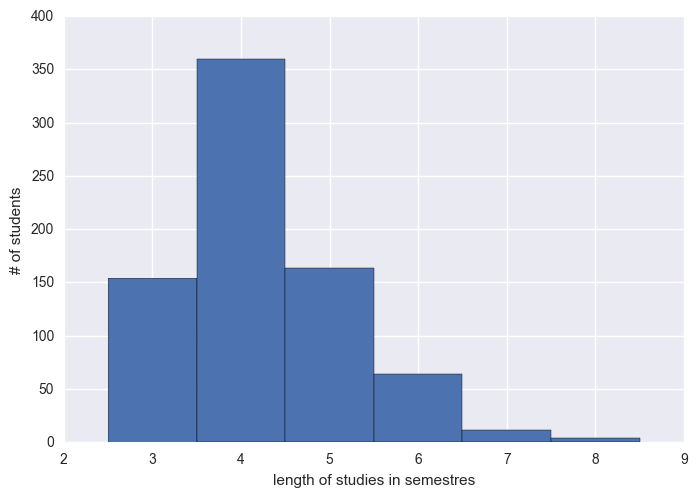

In [35]:
plot_data = []
sem_sum_list = []
for key, val in result_dict.items():
    sem_sum = val['sem_count'] + val['c_sem_count'] + val['s_sem_count'] + val['p_sem_count'] + val['pc_sem_count'] + val['ps_sem_count']
    sem_sum_list.append(sem_sum)
    plot_data.append((min([int(sem[-4:]) + (0 if int(sem[0]) % 2 == 1 else 0.5) for sem in val['sems'] + val['c_sems'] + val['s_sems']]), sem_sum, val['gender']))

min_sems = min(sem_sum_list)
print('min:' + str(min_sems))
max_sems = max(sem_sum_list)
print('max:' + str(max_sems))

import statistics
print('median:' + str(statistics.median(sem_sum_list)))

import matplotlib.pyplot as plt
import numpy as np
a = np.arange(min_sems - 0.5,max_sems + 1.5, 1)
plt.hist(sem_sum_list, bins = a)
plt.xlabel('length of studies in semestres')
plt.ylabel('# of students')
plt.show()

We had a look at some metrics of our data to see if everything fits well.

We see that minimum number of semesters in our data is 3.
That reflects a reality well as it can be achieved by not doing any minor nor specialization, thus doing 2 semestres, doing the internship in summer and finishing the thesis in one semester.

The maximum number of semesters is 8.
In reality the maximum is 9 as with minor or specialization one has to do at least 3 semestres of courses while the double of this is the maximum number of semestres to finish courses.
Then add internship during the semester and 2 semestres to finish the master thesis and we get 9.

However, we do not have any such extreme cases.
The reason might be that because of missing lots of records for master thesis we assumed that it takes only one semester to finish the thesis for a person with missing records.

The median is 4 which makes sense again as the average for males is 4.25 and for females 4.28 while having very little variance, i.e. we don't have any large number (in orders of magnitude) that would push average far away from the median.

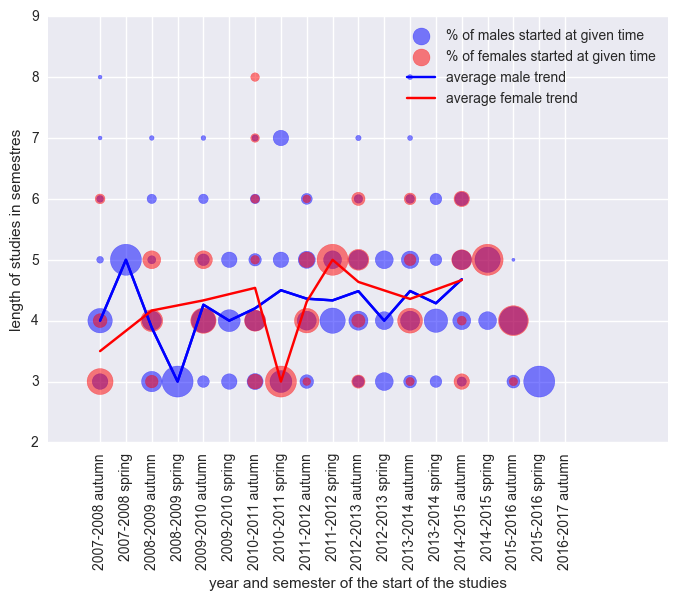

In [39]:
plt.figure()

years = np.arange(2007, 2016.5, 0.5)
sems = np.arange(min_sems, max_sems + 1)
size_m = np.zeros((len(years), len(sems))) 
size_f = np.zeros((len(years), len(sems))) 
for year, sem, gender in plot_data:
    if gender == 1:
        size_m[int((year - 2007)*2), sem - min_sems] += 1 
    else:
        size_f[int((year - 2007)*2), sem - min_sems] += 1 

size_m_sum = size_m.sum(1)
size_m_sum[size_m_sum == 0] = np.inf
average_over_years_m = (size_m * np.arange(min_sems, max_sems + 1)).sum(1) / size_m_sum
size_m = size_m / size_m_sum[:, None]

size_f_sum = size_f.sum(1)
size_f_sum[size_f_sum == 0] = np.inf
average_over_years_f = (size_f * np.arange(min_sems, max_sems + 1)).sum(1) / size_f_sum
size_f = size_f / size_f_sum[:, None]
        
for sem in sems:
    p_scat_m = plt.scatter(years,
                    sem * np.ones(len(years)),
                    marker='o',
                    color='b',
                    alpha=0.5,
                    s=size_m[:,sem - min_sems] * 500
                   )

    p_scat_f = plt.scatter(years,
                    sem * np.ones(len(years)),
                    marker='o',
                    color='r',
                    alpha=0.5,
                    s=size_f[:,sem - min_sems] * 500
                   )
plt.plot(years[:-4], average_over_years_m[:-4], color='b')

no_of_last_sample_to_ignore = 3
p_trend_m, = plt.plot(years[:-no_of_last_sample_to_ignore - 1], average_over_years_m[:-no_of_last_sample_to_ignore - 1], color='b')

not_ok_ind = (average_over_years_f == 0).ravel().nonzero()[0]
ok_ind = (average_over_years_f != 0).ravel().nonzero()[0]
ok_val = average_over_years_f[average_over_years_f!=0]
average_over_years_f[average_over_years_f==0] = np.interp(not_ok_ind, ok_ind, ok_val)
p_trend_f, = plt.plot(years[:-no_of_last_sample_to_ignore - 1], average_over_years_f[:-no_of_last_sample_to_ignore - 1], color='r')

plt.xlabel('year and semester of the start of the studies')
plt.xticks(years, [str(int(year / 1)) + '-' + str(int(year / 1) + 1) + ' ' + ('autumn' if year % 1 == 0 else 'spring') for year in years], size='small', rotation=90)
plt.ylabel('length of studies in semestres')

lgnd = plt.legend((p_scat_m, p_scat_f, p_trend_m, p_trend_f),
          ('% of males started at given time', '% of females started at given time', 'average male trend', 'average female trend'),
          scatterpoints=1)
lgnd.legendHandles[0]._sizes = [150]
lgnd.legendHandles[1]._sizes = [150]

Finally, we plot the scatter plot to analyze the number of semesters it took for students of each gender to finish the studies starting at different semesters and years.

The size of the point represents percentage of students of given gender who started studying at given year. In other words, the sum of sizes of blue circles equals the sum of sizes of red circles at given column.

One might read from the plot that the trend is going steeply down during the last 3 semester. However, this is far from true: The reason for the steep downtrend in the end is that we have assumed that students will finish as soon as possible.
In other words we assumed that persons who is this semester (_Autumn 2016-2017_) in their 2nd semester will finish their studies with the thesis next semester and the very same for students studying minors or taking specializations in their 3rd semestre.
Also, we potentially "shortened" studies of people starting in Autumn and Spring semesters of 2014-2015 as well. Thus we have decided to disregard these semesters, with an exception for Autumn 2014-2015. We consider that semester statistically significant, because the amount of people studying 7 or 8 semestres over the years is very small. We assume that this trend continues and thus the average in Autumn semestre 2014-2015 will increase only insignificantly.

We can see that in some columns red circles miss completely, technically for every other column. These columns represent students starting in the second (spring) semester of the school year. These students are those who finished their bachelor at EPFL in the autumn semester and thus start the master in the spring semester. Given that everybody else starts studying in the first (autumn) semester, the number of such students is usually very low. Given that number of women in IN is very small it usually happens that there is no female starting her studies in the spring semestre. We decided to verify this (see cell below). Thus, we have interpolated missing values in female average trend. 

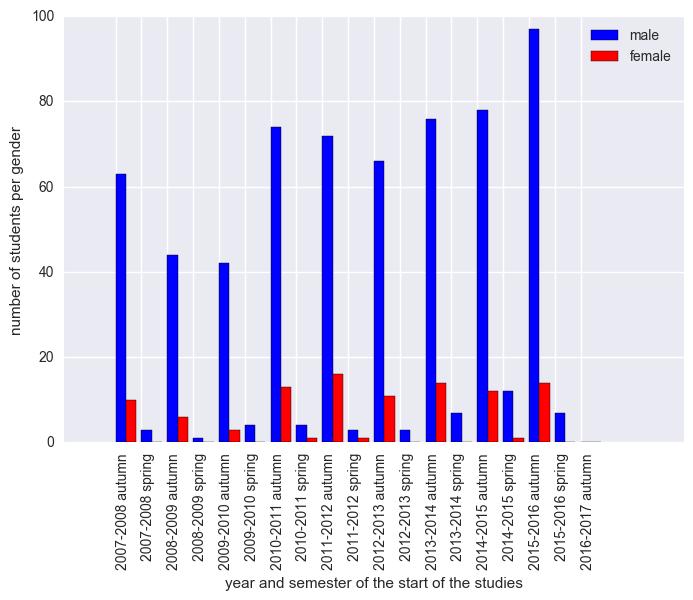

In [44]:
no_of_f_per_sem = size_f_sum
no_of_f_per_sem[no_of_f_per_sem==np.inf] = 0

no_of_m_per_sem = size_m_sum
no_of_m_per_sem[no_of_m_per_sem==np.inf] = 0

plt.figure()

width = 0.20

b_m = plt.bar(years, no_of_m_per_sem, width, color='b')

b_f = plt.bar(years +width, no_of_f_per_sem, width, color='r')

plt.xlabel('year and semester of the start of the studies')
plt.xticks(years, [str(int(year / 1)) + '-' + str(int(year / 1) + 1) + ' ' + ('autumn' if year % 1 == 0 else 'spring') for year in years], size='small', rotation=90, ha='left')
plt.ylabel('number of students per gender')

plt.legend((b_m, b_f),
          ('male', 'female'))

We can see that number of students starting in spring semestre is very tiny. Thus calculations based on them cannot be very statistically significant. Therefore, we have decided to disregard these semesters (see cell below).

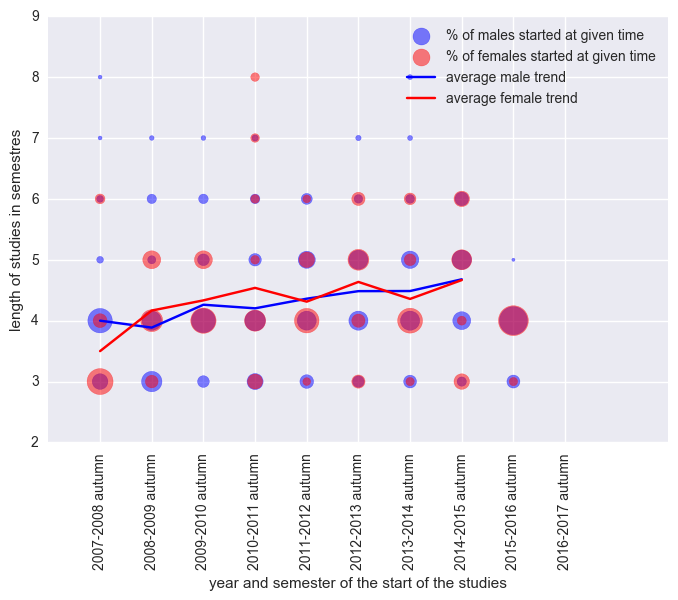

In [38]:
plt.figure()

years = np.arange(2007, 2016 + 1)
sems = np.arange(min_sems, max_sems + 1)
size_m = np.zeros((len(years), len(sems))) 
size_f = np.zeros((len(years), len(sems))) 
for year, sem, gender in plot_data:
    if year % 1 != 0:
        continue
    if gender == 1:
        size_m[year - 2007, sem - min_sems] += 1 
    else:
        size_f[year - 2007, sem - min_sems] += 1 

size_m_sum = size_m.sum(1)
size_m_sum[size_m_sum == 0] = np.inf
average_over_years_m = (size_m * np.arange(min_sems, max_sems + 1)).sum(1) / size_m_sum
size_m = size_m / size_m_sum[:, None]

size_f_sum = size_f.sum(1)
size_f_sum[size_f_sum == 0] = np.inf
average_over_years_f = (size_f * np.arange(min_sems, max_sems + 1)).sum(1) / size_f_sum
size_f = size_f / size_f_sum[:, None]
        
for sem in sems:
    p_scat_m = plt.scatter(years,
                sem * np.ones(len(years)),
                marker='o',
                color='b',
                alpha=0.5,
                s=size_m[:,sem - min_sems] * 500
               )

    p_scat_f = plt.scatter(years,
                sem * np.ones(len(years)),
                marker='o',
                color='r',
                alpha=0.5,
                s=size_f[:,sem - min_sems] * 500
               )
    
no_of_last_sample_to_ignore = 1
p_trend_m, = plt.plot(years[:-no_of_last_sample_to_ignore - 1], average_over_years_m[:-no_of_last_sample_to_ignore - 1], color='b')

not_ok_ind = (average_over_years_f == 0).ravel().nonzero()[0]
ok_ind = (average_over_years_f != 0).ravel().nonzero()[0]
ok_val = average_over_years_f[average_over_years_f!=0]
average_over_years_f[average_over_years_f==0] = np.interp(not_ok_ind, ok_ind, ok_val)
p_trend_f, = plt.plot(years[:-no_of_last_sample_to_ignore - 1], average_over_years_f[:-no_of_last_sample_to_ignore - 1], color='r')

plt.xlabel('year and semester of the start of the studies')
plt.xticks(years, [str(int(year / 1)) + '-' + str(int(year / 1) + 1) + ' ' + ('autumn' if year % 1 == 0 else 'spring') for year in years], size='small', rotation=90)
plt.ylabel('length of studies in semestres')

lgnd = plt.legend((p_scat_m, p_scat_f, p_trend_m, p_trend_f),
          ('% of males started at given time', '% of females started at given time', 'average male trend', 'average female trend'),
          scatterpoints=1)
lgnd.legendHandles[0]._sizes = [150]
lgnd.legendHandles[1]._sizes = [150]

We can see that the trend is much smoother now. The decision about disregarding last few semesters (explained at previous scatter plot) was kept for the very same reasons.

The trend for male students is slowly but obviously increasing over the years. For females we conclude the same while we assume that slight fluctuations are present only due to insufficient amount of samples. 

TODO check statistical significance